In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from cmcrameri import cm
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from math import sqrt
# from math import log, e
import os

# N=100

## MLP

In [34]:
# loading results:
file_path = r"..\results\data\MLP_experiment_N100_2024-04-24_17-29-00\MLP\MLP_N100_results.csv"
df_MLP = pd.read_csv(file_path)
df_MLP


,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,1.00000
...,...,...
65,5,0.37500
66,4,0.59375
67,3,0.43750
68,2,0.56250


## CNN

In [35]:
# loading results:
file_path = r"..\results\data\CNN_exp_N100_2024-05-03_18-08-16\CNN\CNN_N100_results.csv"
df_CNN = pd.read_csv(file_path)
df_CNN


,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,1.00000
...,...,...
65,5,0.40625
66,4,0.43750
67,3,0.40625
68,2,0.46875


## VGG

In [36]:
# loading results:
file_path = r"..\results\data\VGG_experiment_N100_2024-04-24_17-42-48\VGG16\VGG16_N100_results.csv"
df_VGG = pd.read_csv(file_path)
df_VGG

,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,0.96875
...,...,...
65,5,0.50000
66,4,0.46875
67,3,0.53125
68,2,0.40625


Comparison plot for N=100:

Text(0.5, 1.0, 'Comparison of the models for N=100')

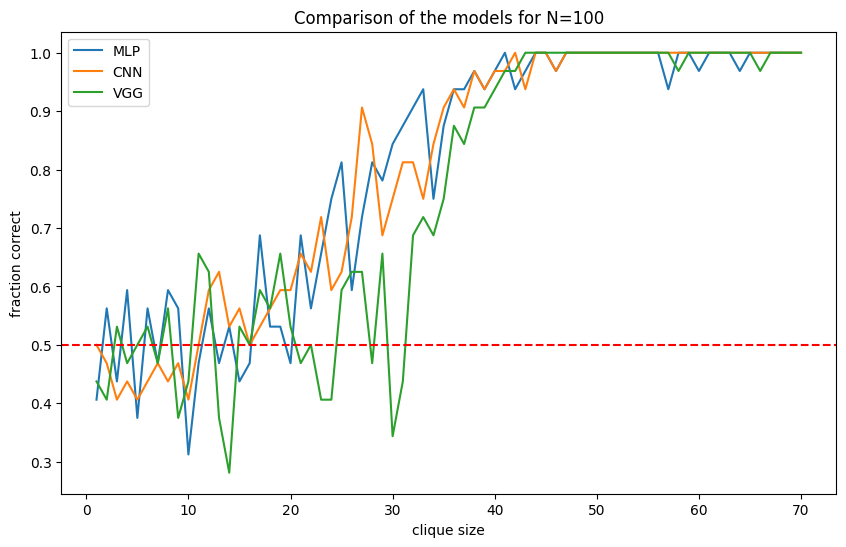

In [37]:
# creating plot for comparison:
plt.figure(figsize=(10, 6))
# adding data from the different models to the same plot using matplotlib:
# - MLP
sns.lineplot(data=df_MLP, x=df_MLP['clique size'], y=df_MLP['fraction correct'], label='MLP')
# - CNN
sns.lineplot(data=df_CNN, x=df_CNN['clique size'], y=df_CNN['fraction correct'], label='CNN')
# - VGG
sns.lineplot(data=df_VGG, x=df_VGG['clique size'], y=df_VGG['fraction correct'], label='VGG')
# - horizontal dashed line at 0.5:
plt.axhline(y=0.5, color='red', linestyle='--')
# set title:
plt.title("Comparison of the models for N=100")

## Fitting the data with sigmoid function

In [38]:
# Add the "model" column to each dataframe
df_MLP['model'] = 'MLP'
df_CNN['model'] = 'CNN'
df_VGG['model'] = 'VGG'

# Adding k/sqrt(n) variable
df_MLP['k/sqrt(n)'] = df_MLP['clique size'] / sqrt(100)
df_CNN['k/sqrt(n)'] = df_CNN['clique size'] / sqrt(100)
df_VGG['k/sqrt(n)'] = df_VGG['clique size'] / sqrt(100)

# Concatenate the dataframes
df_models = pd.concat([df_MLP, df_CNN, df_VGG], ignore_index=True)

# rename variable "clique size" to "K"
df_models.rename(columns={'clique size': 'k'}, inplace=True)

# Print the concatenated dataframe
df_models


,k,fraction correct,model,k/sqrt(n)
0,70,1.00000,MLP,7.0
1,69,1.00000,MLP,6.9
2,68,1.00000,MLP,6.8
3,67,1.00000,MLP,6.7
4,66,1.00000,MLP,6.6
...,...,...,...,...
205,5,0.50000,VGG,0.5
206,4,0.46875,VGG,0.4
207,3,0.53125,VGG,0.3
208,2,0.40625,VGG,0.2


In [39]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2
# creating unique array and populating it:
fitted_params_models = []
for df in [df_MLP, df_CNN, df_VGG]:
    fitted_params_models.append(curve_fit(sigmoid, df['clique size'], df['fraction correct'], p0=(70, 20))[0])
print(fitted_params_models)  

# put these into a dataframe:
df_fitted_params_models = pd.DataFrame(fitted_params_models, columns=['k0', 'delta'])
df_fitted_params_models['model'] = ['MLP', 'CNN', 'VGG']  
df_fitted_params_models

[array([27.40006592,  7.78344133]), array([27.90846195,  9.16300541]), array([34.85415098,  3.55898555])]


,k0,delta,model
0,27.400066,7.783441,MLP
1,27.908462,9.163005,CNN
2,34.854151,3.558986,VGG


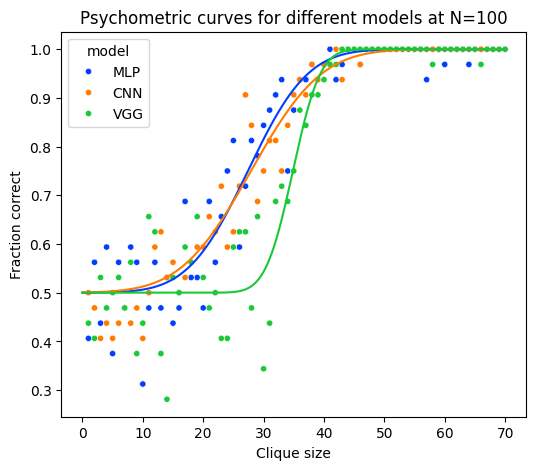

In [40]:
# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(6, 5))

# defining model names
model_names = ['MLP', 'CNN', 'VGG']

# defining x values
x_vals = np.linspace(0, 70, 1000)

# creating palette for the graph
my_palette_models = sns.color_palette("bright", len(model_names))

# Scatter plot based on unique dataframe:
sns.scatterplot(data=df_models, x='k', y='fraction correct', hue='model', palette=my_palette_models, ax=ax, s=20)

# defining y values for each N value and plotting it
for index, model in enumerate(model_names):
    y_vals = (1 + ndtr((x_vals - fitted_params_models[index][0]) / fitted_params_models[index][1])) / 2
    ax.plot(x_vals, y_vals, color=my_palette_models[index])

# setting labels
# ax.set_xlim(ax.get_xlim()[0], 80)
# ax.set_ylim(0.2, 1.03)
ax.set_ylabel("Fraction correct")
ax.set_xlabel("Clique size")    
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_title("Psychometric curves for different models at N=100")

# # Remove y ticks that have no meaning
# yticks = ax.get_yticks()
# yticks = [tick for tick in yticks if tick <= 1]
# ax.set_yticks(yticks)

# # Change legend name to "number of nodes"
# handles, labels = ax.get_legend_handles_labels()
# legend = ax.legend(handles, labels, title="Number of nodes", loc='lower right')

# # Drawing K0 and delta for N=1000
# line_x = fitted_params_machines[7][0]
# line_color = my_palette_models[1]
# y_vals = (1 + ndtr((x_vals - fitted_params_machines[7][0]) / fitted_params_machines[7][1])) / 2
# line_y = np.interp(line_x, x_vals, y_vals)

# # Draw vertical dashed line that stops at the curve
# ax.plot([line_x, line_x], [0, line_y], color=my_palette_models[7], linestyle='--', label='K0')

# # Add label "K0" next to the vertical line
# ax.text(130, 0.5, 'K₀', color=my_palette_models[7], ha='left', va='top')

# # Add horizontal error bar
# delta_bar_width = fitted_params_machines[7][1]
# ax.errorbar(line_x, line_y, xerr=delta_bar_width/2, color=my_palette_models[7], capsize=3)

# # Add label "delta" next to the vertical line
# ax.text(160, 0.74, r'$\Delta$', color=my_palette_models[7], ha='left', va='bottom')

# # Decrease scatter plot marker size
# scatter_collection = ax.collections[0]
# scatter_collection.set_sizes([15])

# saving figure in folder "figures" with 300dpi
fig.savefig('../results/plots/single_experiments_N100_2024-04-24/models_comparison_fc_over_k.png', dpi=300)

# Show the plot
plt.show()

# N= 200

This code is just used for progress report presentation (testing phase visualization)

In [13]:
# importing data for MLP
file_path = r"..\results\data\grid_exp_2024-05-16_14-32-11\N200\MLP\MLP_N200_results.csv"
df_MLP_200 = pd.read_csv(file_path)
df_MLP_200

,clique size,fraction correct
0,140,1.00000
1,138,1.00000
2,137,0.96875
3,135,1.00000
4,134,0.93750
...,...,...
95,6,0.53125
96,5,0.43750
97,3,0.59375
98,2,0.65625


In [14]:
# Add the "model" column to dataframe
df_MLP_200['model'] = 'MLP'

# Adding k/sqrt(n) variable
df_MLP_200['k/sqrt(n)'] = df_MLP_200['clique size'] / sqrt(200)

# rename variable "clique size" to "K"
df_MLP_200.rename(columns={'clique size': 'k'}, inplace=True)

# Print the concatenated dataframe
df_MLP_200

,k,fraction correct,model,k/sqrt(n)
0,140,1.00000,MLP,9.899495
1,138,1.00000,MLP,9.758074
2,137,0.96875,MLP,9.687363
3,135,1.00000,MLP,9.545942
4,134,0.93750,MLP,9.475231
...,...,...,...,...
95,6,0.53125,MLP,0.424264
96,5,0.43750,MLP,0.353553
97,3,0.59375,MLP,0.212132
98,2,0.65625,MLP,0.141421


[array([59.71324581, 17.94694936])]


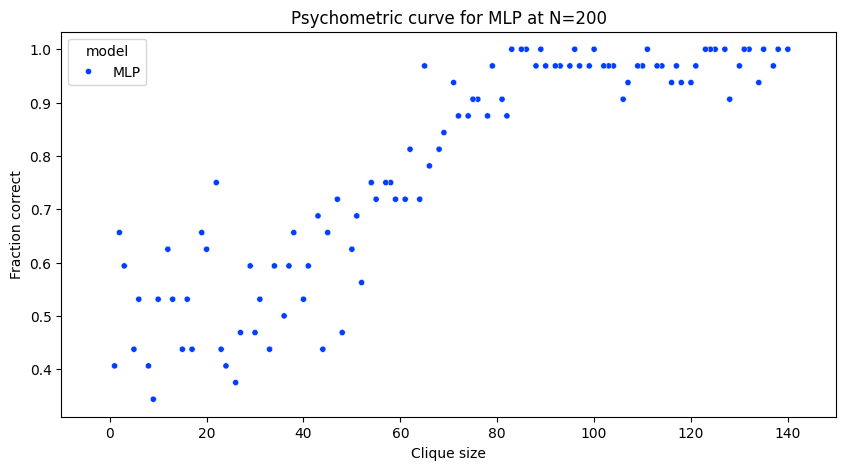

In [20]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2

# creating unique array and populating it:
fitted_params_models = []
fitted_params_models.append(curve_fit(sigmoid, df_MLP_200['k'], df_MLP_200['fraction correct'], p0=(70, 20))[0])
print(fitted_params_models)  

# put these into a dataframe:
df_fitted_params_models = pd.DataFrame(fitted_params_models, columns=['k0', 'delta'])
df_fitted_params_models['model'] = ['MLP']  
df_fitted_params_models


# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(10, 5))

# defining model names
model_names = ['MLP']

# defining x values
x_vals = np.linspace(0, 145, 1000)

# creating palette for the graph
my_palette_models = sns.color_palette("bright", len(model_names))

# Scatter plot based on unique dataframe:
sns.scatterplot(data=df_MLP_200, x='k', y='fraction correct', hue='model', palette=my_palette_models, ax=ax, s=20)

# # defining y values for each N value and plotting it
# for index, model in enumerate(model_names):
#     y_vals = (1 + ndtr((x_vals - fitted_params_models[index][0]) / fitted_params_models[index][1])) / 2
#     ax.plot(x_vals, y_vals, color=my_palette_models[index])

# setting labels
ax.set_xlim(-10, 150)
# ax.set_ylim(0.2, 1.03)
ax.set_ylabel("Fraction correct")
ax.set_xlabel("Clique size")    
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_title("Psychometric curve for MLP at N=200")

# Show the plot
plt.show()

# N=300

## MLP

In [41]:
# loading results:
file_path = r"..\results\data\GLOBAL_exp_N300_2024-05-06_16-27-23\MLP\MLP_N300_results.csv"
df_MLP = pd.read_csv(file_path)
df_MLP


,clique size,fraction correct
0,210,1.00000
1,209,0.93750
2,208,1.00000
3,207,1.00000
4,206,1.00000
...,...,...
205,5,0.65625
206,4,0.37500
207,3,0.53125
208,2,0.59375


## CNN

In [42]:
# loading results:
file_path = r"..\results\data\GLOBAL_exp_N300_2024-05-06_16-27-23\CNN\CNN_N300_results.csv"
df_CNN = pd.read_csv(file_path)
df_CNN


,clique size,fraction correct
0,210,0.56250
1,209,0.56250
2,208,0.50000
3,207,0.43750
4,206,0.56250
...,...,...
205,5,0.25000
206,4,0.56250
207,3,0.59375
208,2,0.34375


## VGG

In [43]:
# loading results:
file_path = r"..\results\data\VGG_experiment_N300_2024-05-06_16-53-59\VGG16\VGG16_N300_results.csv"
df_VGG = pd.read_csv(file_path)
df_VGG

,clique size,fraction correct
0,210,1.00000
1,209,1.00000
2,208,1.00000
3,207,1.00000
4,206,1.00000
...,...,...
205,5,0.34375
206,4,0.59375
207,3,0.56250
208,2,0.43750


## RESNET

In [44]:
# loading results:
file_path = r"..\results\data\RESNET_exp_N300_2024-05-06_17-11-54\RESNET50\RESNET50_N300_results.csv"
df_RESNET = pd.read_csv(file_path)
df_RESNET

,clique size,fraction correct
0,210,1.00000
1,209,1.00000
2,208,1.00000
3,207,1.00000
4,206,1.00000
...,...,...
205,5,0.37500
206,4,0.56250
207,3,0.65625
208,2,0.50000


Comparison plot for N=100:

Text(0.5, 1.0, 'Comparison of the models for N=100')

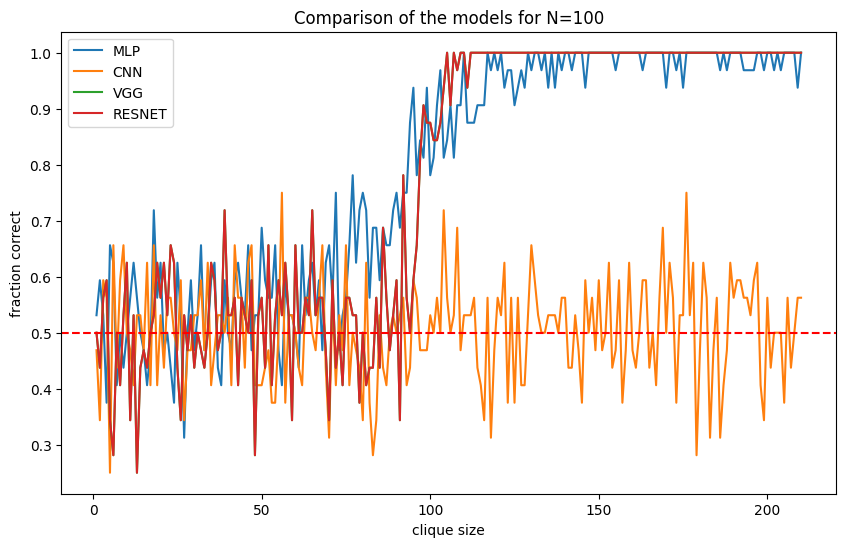

In [45]:
# creating plot for comparison:
plt.figure(figsize=(10, 6))
# adding data from the different models to the same plot using matplotlib:
# - MLP
sns.lineplot(data=df_MLP, x=df_MLP['clique size'], y=df_MLP['fraction correct'], label='MLP')
# - CNN
sns.lineplot(data=df_CNN, x=df_CNN['clique size'], y=df_CNN['fraction correct'], label='CNN')
# - VGG
sns.lineplot(data=df_VGG, x=df_VGG['clique size'], y=df_VGG['fraction correct'], label='VGG')
# - RESNET
sns.lineplot(data=df_RESNET, x=df_RESNET['clique size'], y=df_VGG['fraction correct'], label='RESNET')
# - horizontal dashed line at 0.5:
plt.axhline(y=0.5, color='red', linestyle='--')
# set title:
plt.title("Comparison of the models for N=100")

## Fitting the data with sigmoid function

In [46]:
# Add the "model" column to each dataframe
df_MLP['model'] = 'MLP'
df_CNN['model'] = 'CNN'
df_VGG['model'] = 'VGG'
df_RESNET['model'] = 'RESNET'

# Adding k/sqrt(n) variable
df_MLP['k/sqrt(n)'] = df_MLP['clique size'] / sqrt(100)
df_CNN['k/sqrt(n)'] = df_CNN['clique size'] / sqrt(100)
df_VGG['k/sqrt(n)'] = df_VGG['clique size'] / sqrt(100)
df_RESNET['k/sqrt(n)'] = df_RESNET['clique size'] / sqrt(100)

# Concatenate the dataframes
df_models = pd.concat([df_MLP, df_CNN, df_VGG, df_RESNET], ignore_index=True)

# rename variable "clique size" to "K"
df_models.rename(columns={'clique size': 'k'}, inplace=True)

# Print the concatenated dataframe
df_models


,k,fraction correct,model,k/sqrt(n)
0,210,1.00000,MLP,21.0
1,209,0.93750,MLP,20.9
2,208,1.00000,MLP,20.8
3,207,1.00000,MLP,20.7
4,206,1.00000,MLP,20.6
...,...,...,...,...
835,5,0.37500,RESNET,0.5
836,4,0.56250,RESNET,0.4
837,3,0.65625,RESNET,0.3
838,2,0.50000,RESNET,0.2


In [47]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2
# creating unique array and populating it:
fitted_params_models = []
for df in [df_MLP, df_CNN, df_VGG, df_RESNET]:
    fitted_params_models.append(curve_fit(sigmoid, df['clique size'], df['fraction correct'], p0=(70, 20))[0])
print(fitted_params_models)  

# put these into a dataframe:
df_fitted_params_models = pd.DataFrame(fitted_params_models, columns=['k0', 'delta'])
df_fitted_params_models['model'] = ['MLP', 'CNN', 'VGG', 'RESNET']  
df_fitted_params_models

[array([89.96321075, 23.79287428]), array([497.27621555, 156.00563336]), array([97.37024169,  5.15132563]), array([97.12720615,  8.00834214])]


,k0,delta,model
0,89.963211,23.792874,MLP
1,497.276216,156.005633,CNN
2,97.370242,5.151326,VGG
3,97.127206,8.008342,RESNET


Plotting fitted psychometric curves:

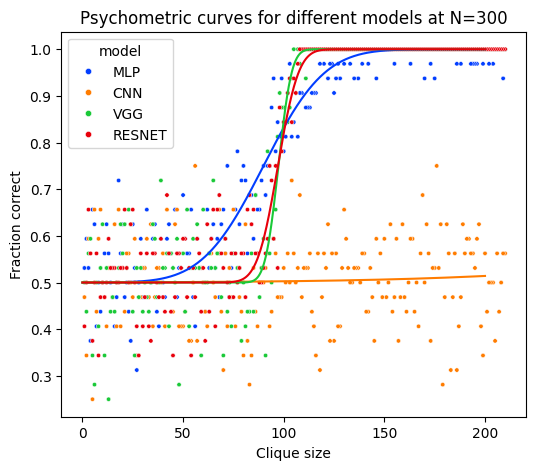

In [48]:
# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(6, 5))

# defining model names
model_names = ['MLP', 'CNN', 'VGG', 'RESNET']

# defining x values
x_vals = np.linspace(0, 200, 1000)

# creating palette for the graph
my_palette_models = sns.color_palette("bright", len(model_names))

# Scatter plot based on unique dataframe:
sns.scatterplot(data=df_models, x='k', y='fraction correct', hue='model', palette=my_palette_models, ax=ax, s=20)

# defining y values for each N value and plotting it
for index, model in enumerate(model_names):
    y_vals = (1 + ndtr((x_vals - fitted_params_models[index][0]) / fitted_params_models[index][1])) / 2
    ax.plot(x_vals, y_vals, color=my_palette_models[index])

# setting labels
# ax.set_xlim(ax.get_xlim()[0], 80)
# ax.set_ylim(0.2, 1.03)
ax.set_ylabel("Fraction correct")
ax.set_xlabel("Clique size")    
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_title("Psychometric curves for different models at N=300")

# # Remove y ticks that have no meaning
# yticks = ax.get_yticks()
# yticks = [tick for tick in yticks if tick <= 1]
# ax.set_yticks(yticks)

# # Change legend name to "number of nodes"
# handles, labels = ax.get_legend_handles_labels()
# legend = ax.legend(handles, labels, title="Number of nodes", loc='lower right')

# # Drawing K0 and delta for N=1000
# line_x = fitted_params_machines[7][0]
# line_color = my_palette_models[1]
# y_vals = (1 + ndtr((x_vals - fitted_params_machines[7][0]) / fitted_params_machines[7][1])) / 2
# line_y = np.interp(line_x, x_vals, y_vals)

# # Draw vertical dashed line that stops at the curve
# ax.plot([line_x, line_x], [0, line_y], color=my_palette_models[7], linestyle='--', label='K0')

# # Add label "K0" next to the vertical line
# ax.text(130, 0.5, 'K₀', color=my_palette_models[7], ha='left', va='top')

# # Add horizontal error bar
# delta_bar_width = fitted_params_machines[7][1]
# ax.errorbar(line_x, line_y, xerr=delta_bar_width/2, color=my_palette_models[7], capsize=3)

# # Add label "delta" next to the vertical line
# ax.text(160, 0.74, r'$\Delta$', color=my_palette_models[7], ha='left', va='bottom')

# Decrease scatter plot marker size
scatter_collection = ax.collections[0]
scatter_collection.set_sizes([10])

# saving figure in folder "figures" with 300dpi
fig.savefig('../results\plots\global_experiment_N300_2024-05-06/models_comparison_fc_over_k_N300.png', dpi=300)

# Show the plot
plt.show()

# Grid experiment:

Fitting procedure for grid experiment. Grid is [100,150,200,300,400,480,600,800,1200]

In [3]:
graph_size_grid = [100,150,200,300,400,480,600,800,1200]
model_names = ["MLP", "CNN", "VGG16", "RESNET50"]
dir_path = r"..\results\data\\"   #ADD DIRECTORY NAME OF GRID EXPERIMENT HERE
# creating dictionary for the whole grid experiment:
"""STRUCTURE:
grid_exp_dict = {
    100: {
        "MLP": MLP_df100,
        "CNN": CNN_df100,
    },
    150: {
        "MLP": MLP_df150,
        "CNN": CNN_df150,
    },
    # ... and so on for other graph sizes
}
"""
grid_exp_dict = {}
# looping through all graph size values:
for graph_size in graph_size_grid:
    # creating dictionary for the current graph size:
    graph_size_dict = {}
    # looping through all models:
    for model_name in model_names:
        # creating file path:
        file_path = dir_path + f"N" + str(graph_size) + "\\" + model_name + "\\" + f"{model_name}.csv"
        # reading data from the file:
        df = pd.read_csv(file_path)
        # Add the "model" column to each dataframe:
        df['model'] = model_name
        # Rename variable "clique size" to "K":
        df.rename(columns={'clique size': 'K'}, inplace=True)
        # adding dataframe to the graph size dictionary:
        graph_size_dict[model_name] = df
        # adding graph size dictionary to the grid experiment dictionary:
        grid_exp_dict[str(graph_size)] = graph_size_dict
        
print(grid_exp_dict)

..\results\data\\N100\MLP\MLP.csv
..\results\data\\N100\CNN\CNN.csv
..\results\data\\N100\VGG16\VGG16.csv
..\results\data\\N100\RESNET50\RESNET50.csv
..\results\data\\N150\MLP\MLP.csv
..\results\data\\N150\CNN\CNN.csv
..\results\data\\N150\VGG16\VGG16.csv
..\results\data\\N150\RESNET50\RESNET50.csv
..\results\data\\N200\MLP\MLP.csv
..\results\data\\N200\CNN\CNN.csv
..\results\data\\N200\VGG16\VGG16.csv
..\results\data\\N200\RESNET50\RESNET50.csv
..\results\data\\N300\MLP\MLP.csv
..\results\data\\N300\CNN\CNN.csv
..\results\data\\N300\VGG16\VGG16.csv
..\results\data\\N300\RESNET50\RESNET50.csv
..\results\data\\N400\MLP\MLP.csv
..\results\data\\N400\CNN\CNN.csv
..\results\data\\N400\VGG16\VGG16.csv
..\results\data\\N400\RESNET50\RESNET50.csv
..\results\data\\N480\MLP\MLP.csv
..\results\data\\N480\CNN\CNN.csv
..\results\data\\N480\VGG16\VGG16.csv
..\results\data\\N480\RESNET50\RESNET50.csv
..\results\data\\N600\MLP\MLP.csv
..\results\data\\N600\CNN\CNN.csv
..\results\data\\N600\VGG16\VGG1

Fitting the data with sigmoid function

In [ ]:
# Create a new dictionary to hold the concatenated dataframes
concat_dfs = {}
"""STRUCTURE:
concat_dfs = {
    100: concatenated_df100,
    150: concatenated_df150,
    # ... and so on for other graph sizes
}
"""
# Loop over the items in the original dictionary
for graph_size, models_dict in grid_exp_dict.items():
    # Concatenate all the dataframes in the models_dict
    concat_dfs[graph_size] = pd.concat(models_dict.values(), ignore_index=True)

print(concat_dfs)

In [ ]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2
# defining dictionary that will store fitted parameters for all graph size value:
""" STRUCTURE:
 fitted_params_dict = {
     100: [fitted_params_MLP100, fitted_params_CNN100, fitted_params_VGG100, fitted_params_RESNET100],
     150: [fitted_params_MLP150, fitted_params_CNN150, fitted_params_VGG150, fitted_params_RESNET150],
     # ... and so on for other graph sizes
 }
"""
fitted_params_dict = {}
# looping through all graph size values:
for graph_size, df_models in concat_dfs.items():
    # creating unique array for each graph size value and populating it:
    fitted_params_models = []
    for df in [df_models[0], df_models[1], df_models[2], df_models[3]]:
        fitted_params_models.append(curve_fit(sigmoid, df['clique size'], df['fraction correct'], p0=(70, 20))[0])
    # adding fitted parameters to the dictionary:
    fitted_params_dict[graph_size] = fitted_params_models
print(fitted_params_dict)

# transform the dictionary values from arrays to dataframes:
""" STRUCTURE:
 fitted_params_df_dict = {
     100: fitted_params_df100,
     150: fitted_params_df150,
     # ... and so on for other graph sizes
 }
"""
fitted_params_df_dict = {}
# looping through all graph size values:
for graph_size, fitted_params_models in fitted_params_dict.items():
    # put these into a dataframe:
    df_fitted_params_models = pd.DataFrame(fitted_params_models, columns=['k0', 'delta'])
    df_fitted_params_models['model'] = model_names
    # adding dataframe to the dictionary:
    fitted_params_df_dict[graph_size] = df_fitted_params_models

print(fitted_params_df_dict)

Plotting fitted psychometric curves for all graph size values.

In [ ]:
# Create a 3x3 plot grid
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(6, 5))

# defining model names
model_names = ['MLP', 'CNN', 'VGG', 'RESNET']

# Looping through all graph size values (NOTE: LOOP TO BE CHECKED):
for index, (graph_size, df_models) in enumerate(concat_dfs.items()):
    # defining x values
    x_vals = np.linspace(0, int(graph_size), 1000)
    # creating palette for the graph
    my_palette_models = sns.color_palette("bright", len(model_names))
    # Scatter plot based on unique dataframe:
    sns.scatterplot(data=df_models, x='clique size', y='fraction correct', hue='model', palette=my_palette_models, ax=ax[index//3, index%3], s=20)
    # defining y values for each N value and plotting it
    for i, model in enumerate(model_names):
        y_vals = (1 + ndtr((x_vals - fitted_params_dict[graph_size][i][0]) / fitted_params_dict[graph_size][i][1])) / 2
        ax[index//3, index%3].plot(x_vals, y_vals, color=my_palette_models[i])
    # setting labels
    ax[index//3, index%3].set_ylabel("Fraction correct")
    ax[index//3, index%3].set_xlabel("Clique size")
    ax[index//3, index%3].tick_params(axis='x')
    ax[index//3, index%3].tick_params(axis='y')
    ax[index//3, index%3].set_title(f"Psychometric curves for different models at N={graph_size}")
    # Decrease scatter plot marker size
    scatter_collection = ax[index//3, index%3].collections[0]
    scatter_collection.set_sizes([10])

# # saving figure in folder "figures" with 300dpi
# fig.savefig('../results\plots\.../grid_experiment_psychometrics.png', dpi=300)

# Show the plot
plt.show()